In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import warnings
warnings.filterwarnings("ignore")

In [3]:
file_path = "/content/drive/MyDrive/household_power_consumption.txt"

df = pd.read_csv(
    file_path,
    sep=";",
    na_values=['?'],
    low_memory=False
)

df['Datetime'] = pd.to_datetime(df['Date'] + " " + df['Time'], format="%d/%m/%Y %H:%M:%S")

df = df.set_index('Datetime')
df = df.drop(columns=['Date', 'Time'])

df = df.astype(float)

print(df.head())

                     Global_active_power  Global_reactive_power  Voltage  \
Datetime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
Datetime                                                                
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00          

In [ ]:
#TASK 1

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64


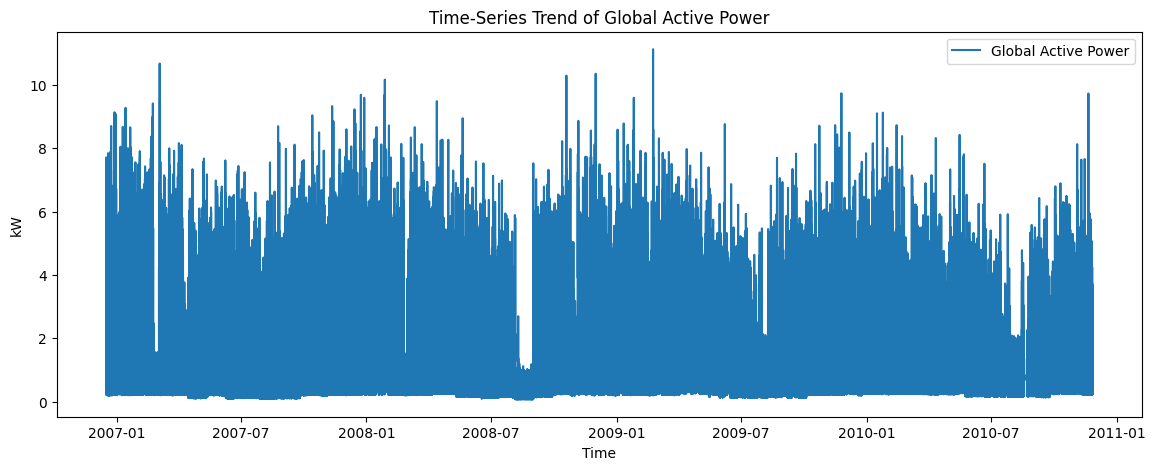

In [4]:
print(df.isna().sum())
df = df.interpolate(method='time')
plt.figure(figsize=(14,5))
plt.plot(df.index, df['Global_active_power'], label="Global Active Power")
plt.title("Time-Series Trend of Global Active Power")
plt.xlabel("Time")
plt.ylabel("kW")
plt.legend()
plt.show()


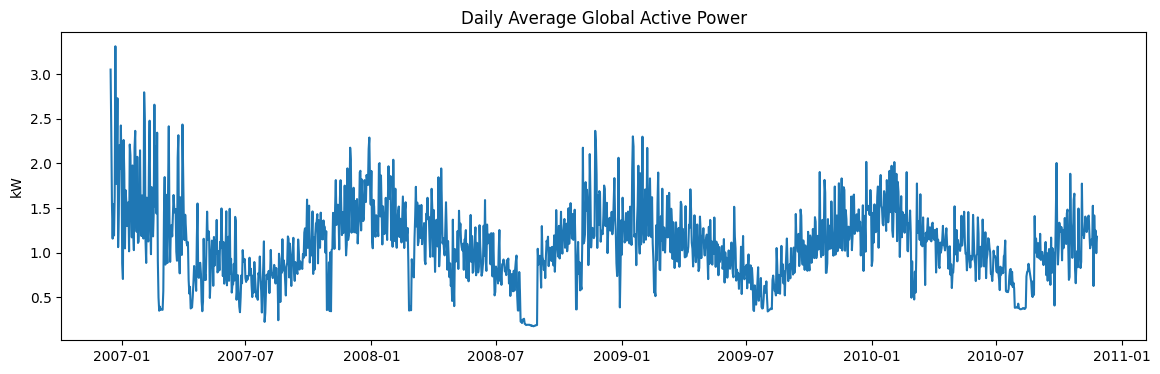

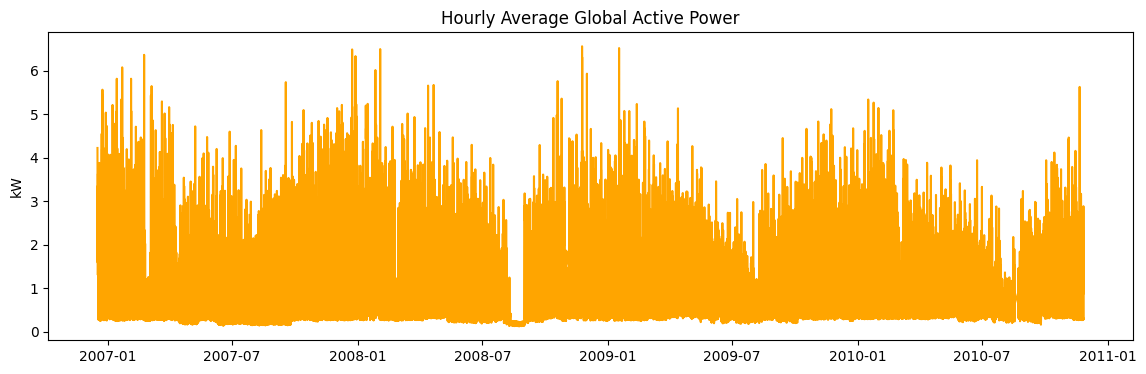

In [5]:
daily = df['Global_active_power'].resample('D').mean()

plt.figure(figsize=(14,4))
plt.plot(daily.index, daily)
plt.title("Daily Average Global Active Power")
plt.ylabel("kW")
plt.show()
hourly = df['Global_active_power'].resample('H').mean()

plt.figure(figsize=(14,4))
plt.plot(hourly.index, hourly, color='orange')
plt.title("Hourly Average Global Active Power")
plt.ylabel("kW")
plt.show()


In [ ]:
#TASK 2

In [6]:
data = df[['Global_active_power']]
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)
def create_dataset(series, window=60):
    X, y = [], []
    for i in range(window, len(series)):
        X.append(series[i-window:i])
        y.append(series[i])
    return np.array(X), np.array(y)

X, y = create_dataset(scaled, 60)
split = int(len(X)*0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [9]:
model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(60,1)),
    LSTM(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

history = model.fit(X_train, y_train, epochs=2, batch_size=64, validation_split=0.1)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
23346/23346 ━━━━━━━━━━━━━━━━━━━━ 1654s 71ms/step - loss: 8.1953e-04 - val_loss: 5.2548e-04
Epoch 2/2
23346/23346 ━━━━━━━━━━━━━━━━━━━━ 1689s 72ms/step - loss: 5.6241e-04 - val_loss: 5.0772e-04


12970/12970 ━━━━━━━━━━━━━━━━━━━━ 213s 16ms/step
MAE: 0.08732154802443995
RMSE: 0.20409322555718137


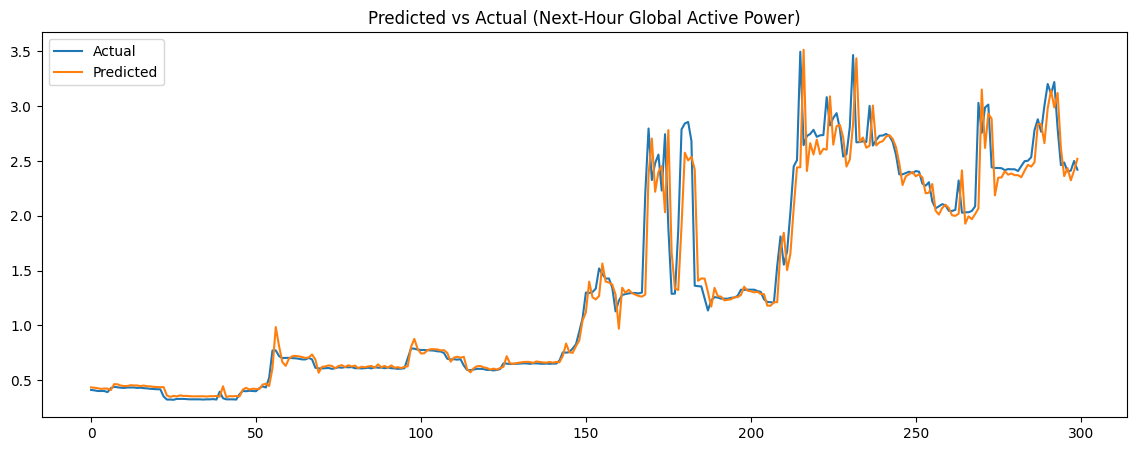

In [10]:
y_pred = model.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

MAE = mean_absolute_error(y_test_inv, y_pred_inv)
RMSE = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

print("MAE:", MAE)
print("RMSE:", RMSE)

plt.figure(figsize=(14,5))
plt.plot(y_test_inv[:300], label="Actual")
plt.plot(y_pred_inv[:300], label="Predicted")
plt.title("Predicted vs Actual (Next-Hour Global Active Power)")
plt.legend()
plt.show()


In [ ]:
# TASK 3

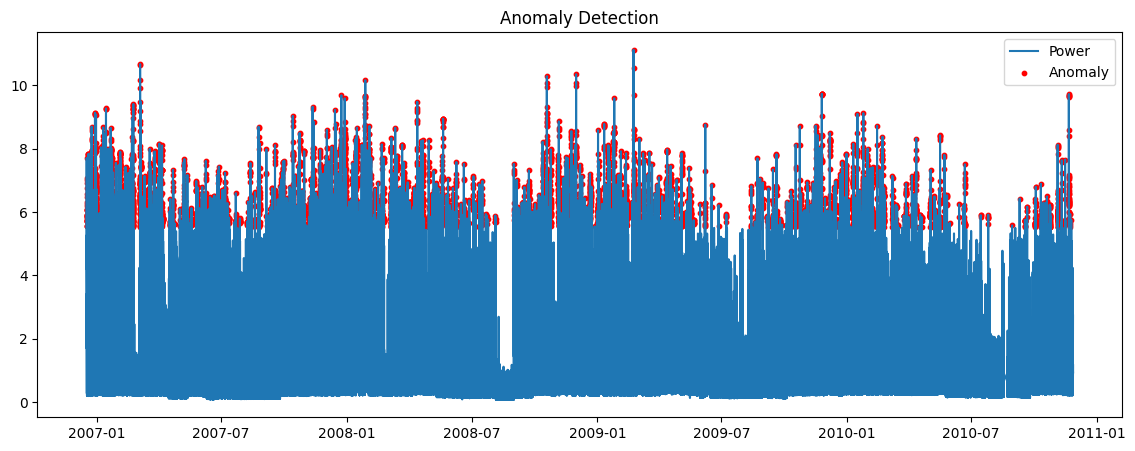

Total Anomalies: 10162


In [12]:
iso = IsolationForest(contamination=0.005, random_state=42)
df['anomaly'] = iso.fit_predict(df[['Global_active_power']])

anomalies = df[df['anomaly'] == -1]

plt.figure(figsize=(14,5))
plt.plot(df.index, df['Global_active_power'], label="Power")
plt.scatter(anomalies.index, anomalies['Global_active_power'],
            color='red', s=10, label="Anomaly")
plt.title("Anomaly Detection")
plt.legend()
plt.show()

print("Total Anomalies:", len(anomalies))


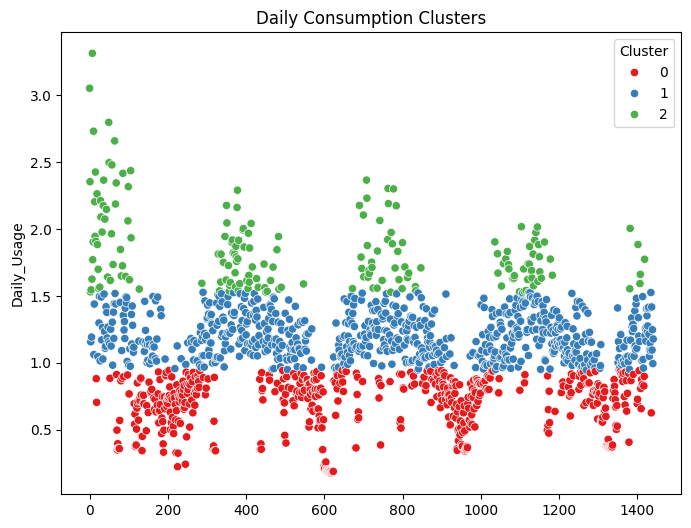

,Daily_Usage
Cluster,
0,0.686283
1,1.201723
2,1.846044


In [13]:
daily_usage = df['Global_active_power'].resample("D").mean().dropna()

daily_df = pd.DataFrame({'Daily_Usage': daily_usage.values})

kmeans = KMeans(n_clusters=3, random_state=42)
daily_df['Cluster'] = kmeans.fit_predict(daily_df[['Daily_Usage']])

plt.figure(figsize=(8,6))
sns.scatterplot(x=range(len(daily_df)), y='Daily_Usage', hue='Cluster', data=daily_df, palette="Set1")
plt.title("Daily Consumption Clusters")
plt.show()

daily_df.groupby("Cluster").mean()


In [ ]:
# TASK 4

In [14]:
def usage_category(power):
    if power < 1.5:
        return "Low Usage", "Energy usage is low. Good efficiency maintained."
    elif power < 3.5:
        return "Medium Usage", "Usage is moderate. Turn off unused appliances to save more."
    else:
        return "High Usage", "High consumption! Consider reducing heavy appliances."

example_power = float(y_pred_inv[-1])

cat, suggestion = usage_category(example_power)

print("Predicted Power:", example_power)
print("Category:", cat)
print("Suggestion:", suggestion)


Predicted Power: 0.9336873888969421
Category: Low Usage
Suggestion: Energy usage is low. Good efficiency maintained.
